In [1]:
import numpy as np
import pandas as pd

In [2]:
### DATASET CLEANING CODE, IGNORE UNLESS YOU KNOW WHAT THIS IS ###

# df = pd.read_csv("./temp/yield_df.csv")
# df = df.drop(df[df["Area"] != "India"].index)
# df = df.drop(columns=["Unnamed: 0", "Year", "Area"])
# df.rename(columns={"hg/ha_yield": "ton/ha_yield", "Item": "crop"}, inplace=True)
# df["ton/ha_yield"] = df["ton/ha_yield"] / 10 / 1000

# df.to_csv("./data/crop.yield.prediction.csv", index=False)

In [3]:
df = pd.read_csv("./data/crop.yield.prediction.csv")
df

,crop,ton/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Tapioca (Cassava),20.5381,1083.0,75000.0,25.58
1,Tapioca (Cassava),20.5381,1083.0,75000.0,26.88
2,Tapioca (Cassava),20.5381,1083.0,75000.0,25.79
3,Tapioca (Cassava),20.5381,1083.0,75000.0,24.10
4,Tapioca (Cassava),20.5381,1083.0,75000.0,25.25
...,...,...,...,...,...
4043,Wheat,3.1538,1083.0,45620.0,27.14
4044,Wheat,3.1538,1083.0,45620.0,25.98
4045,Wheat,3.1538,1083.0,45620.0,27.44
4046,Wheat,3.1538,1083.0,45620.0,27.44


In [4]:
unique_crops = np.unique(df["crop"]).tolist()
unique_crops

['Jowar',
 'Maize',
 'Potatoes',
 'Rice, paddy',
 'Soybeans',
 'Sweet potatoes',
 'Tapioca (Cassava)',
 'Wheat']

In [5]:
np.unique(df["average_rain_fall_mm_per_year"])

array([1083.])

In [6]:
df = df.drop(columns=["average_rain_fall_mm_per_year"])

In [7]:
import seaborn as sns

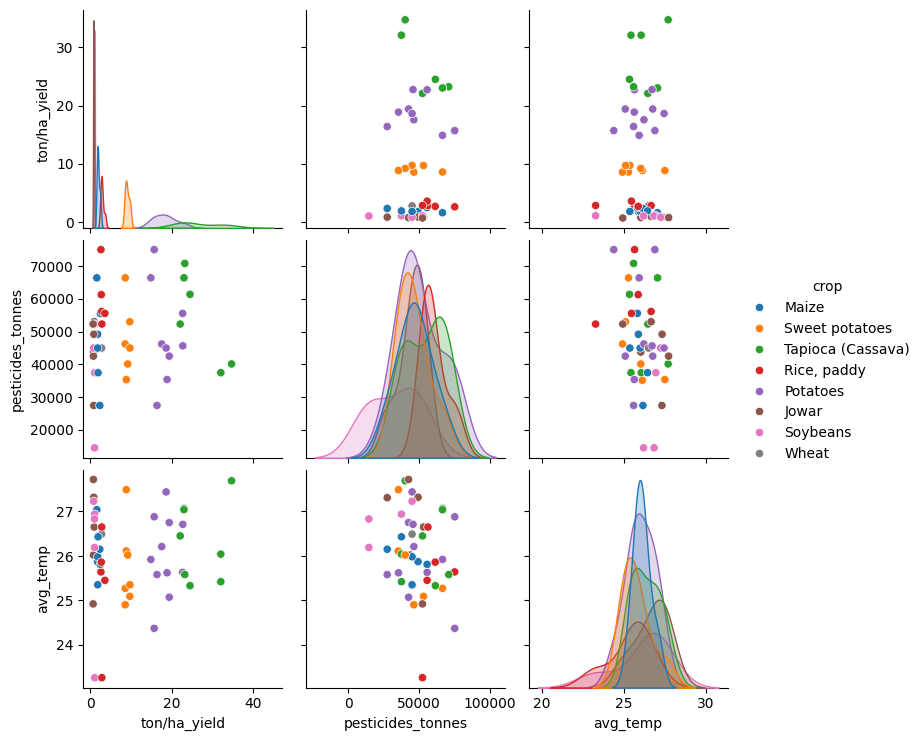

In [8]:
sns.pairplot(df.sample(n=50), hue="crop")

In [9]:
df["crop"] = df["crop"].map(lambda x: unique_crops.index(x))

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
crop,4048.0,3.500000,2.291571,0.0000,1.750000,3.5000,5.2500,7.0000
ton/ha_yield,4048.0,8.088447,9.595022,0.6553,1.370475,2.8124,11.2471,38.5818
pesticides_tonnes,4048.0,48459.040000,14997.351972,14485.3300,37423.000000,46195.0000,61257.0000,75000.0000
avg_temp,4048.0,26.012589,0.909861,23.2600,25.460000,25.9800,26.6700,28.8500


In [11]:
from sklearn.model_selection import train_test_split

X = df.drop("ton/ha_yield", axis=1).to_numpy()
y = df["ton/ha_yield"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time

def run_model(model, fit = True):
    begin = time.time()
    name = model.__class__.__name__

    if fit: 
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    ret = {}

    ret["MAE"] = mean_absolute_error(y_test, y_pred)
    ret["RMSE"] = mean_squared_error(y_test, y_pred, squared=False)
    ret["time"] = time.time() - begin


    fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
    ax[0].set_title(f"test vs predicted data - {name}")
    sns.lineplot(y_test - y_pred, ax=ax[0])
    # sns.lineplot(y_pred, ax=ax[0])

    ax[1].set_title(f"absolute error (fraction) - {name}")
    sns.scatterplot(abs(y_pred - y_test) / y_pred, ax=ax[1], s=2).set_ylim(0, 2)


    return ret

> testing model: RandomForestRegressor
  MAE:  2.08e-05
  RMSE: 0.000547
  time taken: 0.0997s
> testing model: SVR
  MAE:  6.8
  RMSE: 11.3
  time taken: 0.706s
> testing model: Ridge
  MAE:  7.46
  RMSE: 9.33
  time taken: 0.00446s


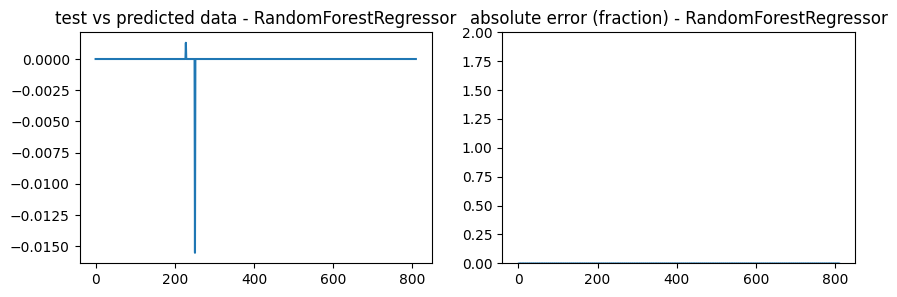

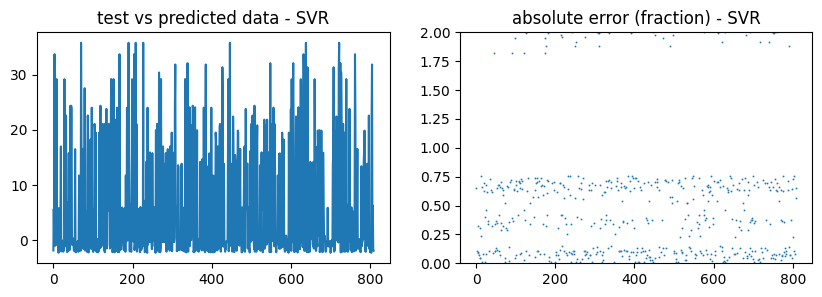

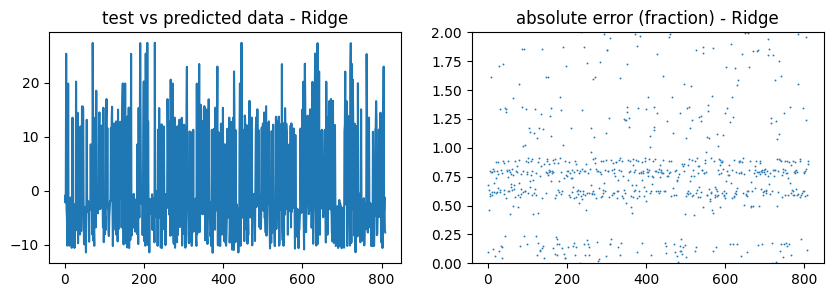

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


regressors = [RandomForestRegressor(random_state=42,n_estimators=20),
              SVR(),
              Ridge(alpha=0.5)]

for model in regressors:
    print(f"> testing model: {model.__class__.__name__}")
    score = run_model(model)
    print(f"  MAE:  {score['MAE'] :.{3}}")
    print(f"  RMSE: {score['RMSE']:.{3}}")
    print(f"  time taken: {score['time']:.{3}}s")

In [14]:
from joblib import dump, load

dump(regressors[0], "./out/yield.prediction.joblib")

['./out/yield.prediction.joblib']

  MAE:  2.08e-05
  RMSE: 0.000547
  time taken: 0.104s


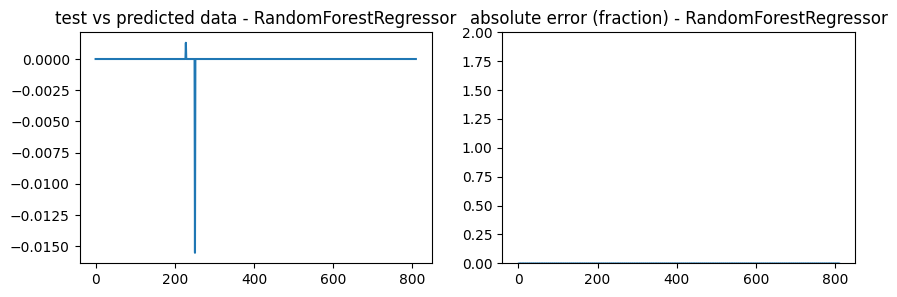

In [15]:
reg = load("./out/yield.prediction.joblib")

score = run_model(reg)
print(f"  MAE:  {score['MAE'] :.{3}}")
print(f"  RMSE: {score['RMSE']:.{3}}")
print(f"  time taken: {score['time']:.{3}}s")